In [1]:
###### Config #####
import sys, os, platform
if os.path.isdir("ds-assets"):
  !cd ds-assets && git pull
else:
  !git clone https://github.com/lutzhamel/ds-assets.git
colab = True if 'google.colab' in os.sys.modules else False
system = platform.system() # "Windows", "Linux", "Darwin"
home = "ds-assets/assets/"
sys.path.append(home)

Already up to date.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme()
#from scipy import stats
from sklearn.datasets import make_blobs
from sklearn.datasets import make_circles
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.linear_model import Perceptron
from sklearn.svm import SVC
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from nltk.stem import PorterStemmer
from dsutils import classification_confint

In [3]:
# aux function
def plot_svm_surface(clf,X,surface_only=False,support_only=False):
  ax = plt.gca()
  if not support_only:
    DecisionBoundaryDisplay.from_estimator(
        clf,
        X,
        plot_method="contour",
        colors="k",
        levels= [0] if surface_only else [-1, 0, 1],
        alpha=0.5,
        linestyles= ["-"] if surface_only else ["--", "-", "--"],
        ax=ax,
    )
  # plot support vectors
  if (not surface_only) or support_only:
    ax.scatter(
        clf.support_vectors_[:, 0],
        clf.support_vectors_[:, 1],
        s=100,
        linewidth=1,
        facecolors="none",
        edgecolors="k",
    )

In [4]:
# aux function
def plot_perceptron_surface(clf, X):
  ax = plt.gca()
  DecisionBoundaryDisplay.from_estimator(
      clf,
      X,
      plot_method="contour",
      levels = [0],
      colors="g",
      alpha=0.5,
      linestyles= '-',
      ax=ax,
  )

# Large Margin Classifiers

Large margin classifiers are a refinement of perceptron learning in that they are classification algorithms that can discriminate between two classes.


## Perceptron Learning

Recall that the perceptron training algorithm keeps modifying the weights and the bias term of the perceptron architecture until a decision surface is found that separates the two classes,

<center>
<img src="https://raw.githubusercontent.com/lutzhamel/ds-assets/main/assets/perceptron-train.jpg"  height="250" width="280">
</center>

Visualizing the search,

<center>
<img src="https://raw.githubusercontent.com/lutzhamel/ds-assets/main/assets/perceptron-learning.gif"  height="400" width="500">
</center>

The training algorithm searches the space of all possible decision surfaces in order to find one that separates the two classes correctly.  Here is the final stage of the search where the algorithm found a decision surface that separates the two classes.

<center>
<img src="https://raw.githubusercontent.com/lutzhamel/ds-assets/main/assets/perceptron-search.png"  height="400" width="500">
</center>


The problem with the learning heuristic for perceptrons is that it can give rise to **suboptimal decision surfaces**.  Consider the figure below,

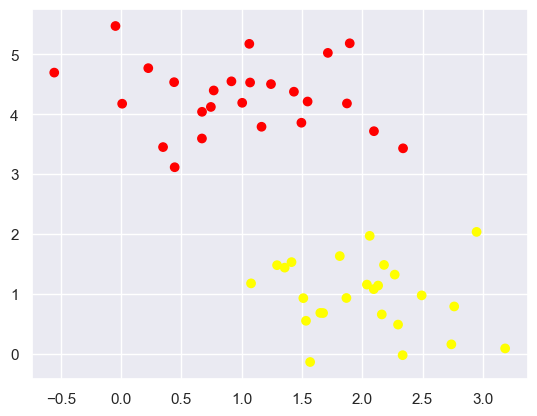

In [5]:
# make our training data
X, y = make_blobs(n_samples=50, centers=2,
                  random_state=0, cluster_std=0.60)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='autumn')

In [6]:
# generate some values between -1 and 3.5
xfit = np.linspace(-1, 3.5)
xfit

array([-1.        , -0.90816327, -0.81632653, -0.7244898 , -0.63265306,
       -0.54081633, -0.44897959, -0.35714286, -0.26530612, -0.17346939,
       -0.08163265,  0.01020408,  0.10204082,  0.19387755,  0.28571429,
        0.37755102,  0.46938776,  0.56122449,  0.65306122,  0.74489796,
        0.83673469,  0.92857143,  1.02040816,  1.1122449 ,  1.20408163,
        1.29591837,  1.3877551 ,  1.47959184,  1.57142857,  1.66326531,
        1.75510204,  1.84693878,  1.93877551,  2.03061224,  2.12244898,
        2.21428571,  2.30612245,  2.39795918,  2.48979592,  2.58163265,
        2.67346939,  2.76530612,  2.85714286,  2.94897959,  3.04081633,
        3.13265306,  3.2244898 ,  3.31632653,  3.40816327,  3.5       ])

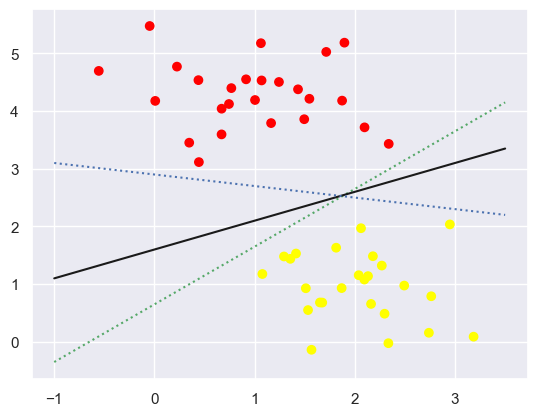

In [7]:
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='autumn')

# plot three decision surfaces
for (slope, offset, color) in [(1, 0.65, ':g'), (0.5, 1.6,'-k'), (-0.2, 2.9,':b')]:
    plt.plot(xfit, slope*xfit+offset, color)

[source](https://jakevdp.github.io/PythonDataScienceHandbook/05.07-support-vector-machines.html)

Here the **suboptimal decision surfaces** are shown as dotted lines. Intuitively we call them suboptimal because each of them has a **higher likelihood to misclassify points** compared to the optimal decision surface shown in black.  Consider the blue dotted decision surface, on the upper left it has a high likelihood of misclassifying red points than the optimal decision surface and at the lower right is has higher likelihood of misclassifying yellow points. Conversely for the green dotted decision surface.  We can observe that the **optimal decision surface has equal likelihood to misclassify either points**.

## Maximizing the Margin

How do we construct the optimal decision surface?  One way to do this is to **maximize the margin**.  You can think of the margin as a **symmetric tube around the decision surface** that fits between the two classes. The optimal decision surface has the largest margin compared to all the other decision surfaces we can construct.

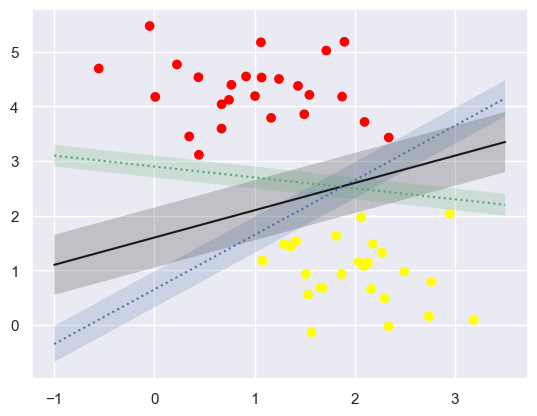

In [8]:
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='autumn')

# decision surfaces with margins
surfaces = [(1, 0.65, 0.33, ':b','b'), (0.5, 1.6, 0.55, '-k','k'), (-0.2, 2.9, 0.2,':g','g')]

for (slope, offset, margin_size, line_color, margin_color) in surfaces:
    yfit = slope * xfit + offset
    # decision surface
    plt.plot(xfit, yfit, line_color)
    # margin
    plt.fill_between(xfit, 
                     yfit - margin_size, 
                     yfit + margin_size, 
                     color=margin_color, 
                     edgecolor='none',
                     alpha=0.2)

**Observation**: Decision surface with large margins have a lower likelihood of misclassification because the class distributions are further away from the decision surface.

# Support Vector Machines

Support vector machines (SVMs) compute the maximum (optimal) margin between two classes and then place the decision surface at the center of the margin.

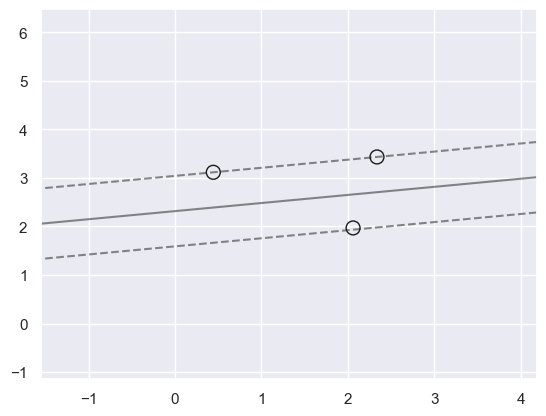

In [9]:
model = SVC(kernel='linear').fit(X, y)
plot_svm_surface(model, X);

As you can see from the figure the margin is limited by points from the two classes.  These limiting points are called **support vectors**.  One way to think about these points is that they **support** the position of the optimal decision surface essentially act as **constraints** on the width and position of the optimal decision surface.

The fact we are using a **linear kernel** in our example means that we are constructing the margin and the decision surface in training data space.  If we use kernels other than the linear kernels we map our training data into  other, extremely high-dimensional spaces and build our SVMs there.  This gives rise to non-linear decision surfaces when we map the decision surface from the high-dimensional space to training data space.

## Comparing SVMs and Perceptrons

We can compare the two algorithms side-by-side.

In [10]:
pmodel = Perceptron().fit(X,y)

Plotting the two decision surfaces.

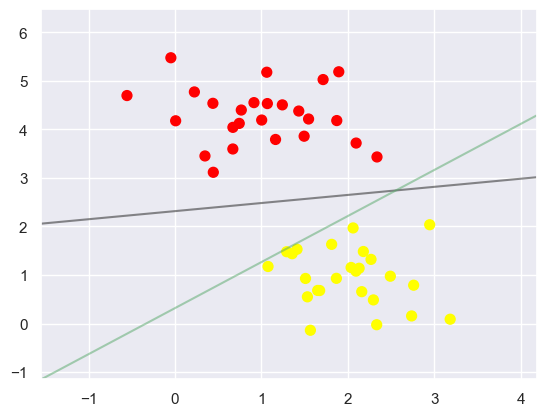

In [11]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svm_surface(model, X, surface_only=True);
plot_perceptron_surface(pmodel,X)

The decision surface for the SVM is given in black and the decision surface for the perceptron is given in green.  We can clearly see that the decision surface for the SVM is what we consider optimal.

## Dealing with Noisy Data - Soft Margins

Let regenerate our original data...

In [12]:
X, y = make_blobs(n_samples=50, centers=2,
                  random_state=0, cluster_std=0.60)

but we will introduce a noisy point...

In [13]:
y[-5] = 0 # introducing noise by mapping a 1 class point to the 0 class

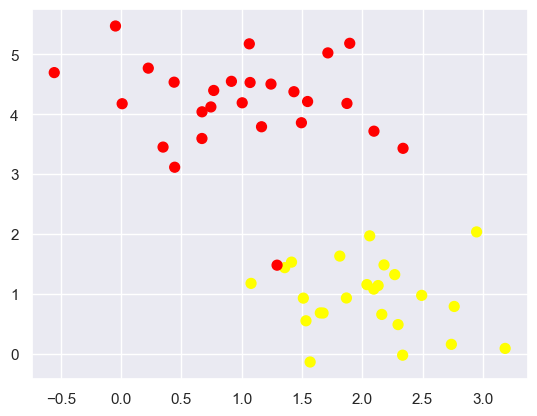

In [14]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')


Notice, there is one red point in the "wrong" class distribution.  Now let's fit an SVM with a hard margin.  Note that

* margin_hardness = 1 is considered a soft margin (more on that further down)
* margin_hardness > 100 is considered a hard margin

In [15]:
margin_hardness = 1000  # very hard margin

The parameter C controls the margin, here we assign it a hardness value of 1,000.

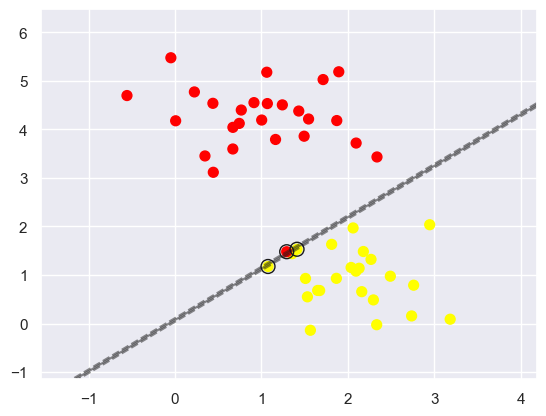

In [16]:
model = SVC(kernel='linear', C=margin_hardness).fit(X, y)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svm_surface(model, X);

Notice that because of that one noisy point we obtain a suboptimal decision surface; a surface very close to the yellow class meaning that has a high likelihood to misclassify yellow points.

Now, let's set the margin hardness to 1 meaning that the margin construction is "soft" and and can ignore noisy points.

In [17]:
margin_hardness = 1

Again, we set the C parameter to our margin hardness for fitting,

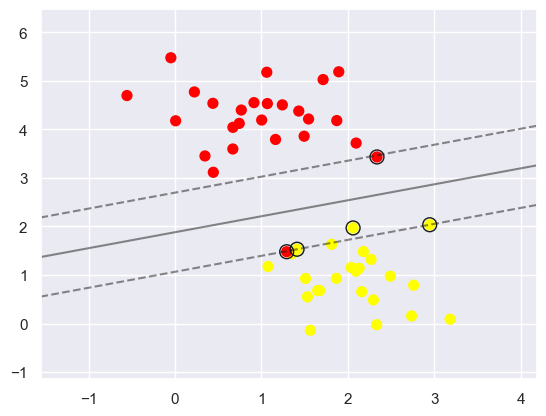

In [18]:
model = SVC(kernel='linear', C=margin_hardness).fit(X, y)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svm_surface(model, X);

Notice that we regained a margin that is optimal or close to optimal.  Also notice that the noisy point is on the wrong side of the decision surface.  In essence, the margin construction ingnored the noisy point in favor of a more optimal decision surface.  Exactly the kind of result we would like to see in noisy data.

Note that the default for SVMs is `C=1`, that is, by default the construction uses soft margins.

## Nonlinear Data

Not all data is separable by a linear decision surface.  For example, in the extreme case where one class is embedded in another class, like so,

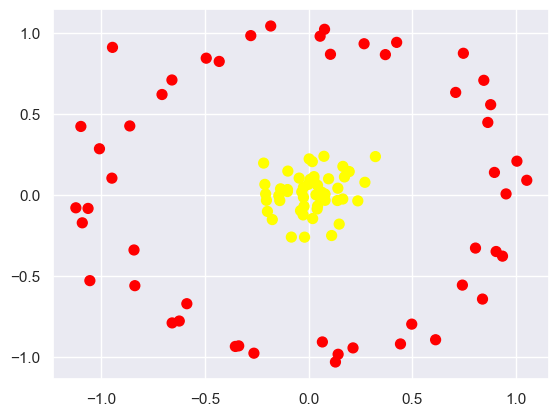

In [19]:
X, y = make_circles(100, factor=.1, noise=.1)

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')

Here we can use **kernels** to model the non-linearities of the data.

Let's use the **radial basis function (rbf)** kernel.  We will also use a **hard margin** because we know that the two classes are well separated.



In [20]:
model = SVC(kernel='rbf', C=1000).fit(X, y)

Let's visualize this decision surface in our training data space.

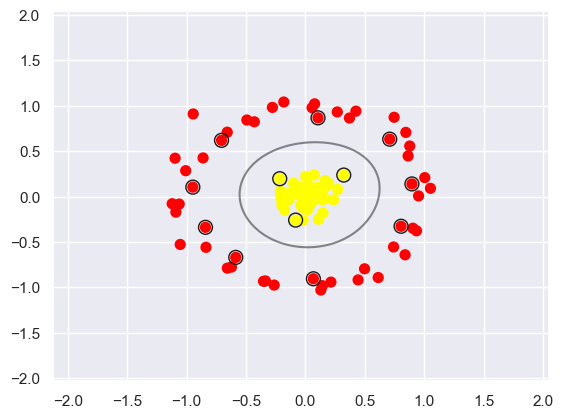

In [21]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svm_surface(model,X,surface_only=True) # show surface
plot_svm_surface(model,X,support_only=True) # show support vectors

We can see the non-linear decision surface with its support vectors

# Example: Text Classification

Because the SVM algorithm does not deteriorate with high dimensional data we can try it on our text classification problem.

In [22]:
# get the newsgroup database
newsgroups = pd.read_csv(home+"newsgroups-noheaders.csv")
newsgroups.head(n=10)

,text,label
0,\nIn billions of dollars (%GNP):\nyear GNP ...,space
1,ajteel@dendrite.cs.Colorado.EDU (A.J. Teel) w...,space
2,\nMy opinion is this: In a society whose econ...,space
3,"Ahhh, remember the days of Yesterday? When we...",space
4,"\n""...a la Chrysler""?? Okay kids, to the near...",space
5,"\n As for advertising -- sure, why not? A N...",politics
6,"\n What, pray tell, does this mean? Just who ...",space
7,\nWhere does the shadow come from? There's no...,politics
8,^^^^^^^^^...,politics
9,"#Yet, when a law was proposed for Virginia tha...",space


In [23]:
# construct the docterm matrix
stemmer = PorterStemmer()
analyzer= CountVectorizer(analyzer = "word",
                          stop_words = 'english',
                          token_pattern = "[a-zA-Z]+")\
            .build_analyzer()
def doc_stemmer(doc):
    return [stemmer.stem(w) for w in analyzer(doc)]
vectorizer = CountVectorizer(analyzer=doc_stemmer,
                             binary=True,
                             min_df=2) 
docterm = pd.DataFrame(data=vectorizer.fit_transform(newsgroups['text']).toarray(), 
                       columns=list(vectorizer.get_feature_names_out()))
docterm

,aa,abandon,abbey,abc,abil,abl,aboard,abolish,abort,abroad,...,yugoslavia,yup,z,zealand,zenit,zero,zeta,zip,zone,zoo
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1033,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1034,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1035,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1036,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [24]:
# set up train and test sets
X_train, X_test, y_train, y_test = \
  train_test_split(docterm,   # as X
                   newsgroups['label'],  # as y
                   train_size=0.8,
                   test_size=0.2,
                   random_state=2)

In [25]:
# model object
model = SVC()

In [26]:
# grid search
param_grid = {
      'kernel':['linear','rbf'],
      'C': [1, 10, 100, 1000],
      'gamma': [0.0001, 0.001, 0.01]
}
grid = GridSearchCV(model, param_grid, cv=3).fit(X_train, y_train)
print("Grid Search: best parameters: {}".format(grid.best_params_))
best_model = grid.best_estimator_

Grid Search: best parameters: {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}


In [27]:
# Evaluate the best model
acc = best_model.score(X_test,y_test)
lb,ub = classification_confint(acc,X_test.shape[0])
print("Accuracy: {:3.2f} ({:3.2f},{:3.2f})".format(acc,lb,ub))

Accuracy: 0.88 (0.84,0.93)


In [28]:
# build the confusion matrix
labels = ['politics','space']
cm = pd.DataFrame(data=confusion_matrix(y_test,best_model.predict(X_test),labels=labels), 
                  index=labels, 
                  columns=labels)
cm

,politics,space
politics,100,9
space,15,84


Putting this into context with all the other classifiers we tried on this dataset:

**decision tree**: Accuracy: 0.74 (0.68,0.80)

**SVM**: Accuracy: 0.88 (0.84,0.93)

**random forest**: Accuracy: 0.90 (0.86,0.94)

**gradient boosting**: Accuracy: 0.91 (0.87,0.95)

**naive bayes**: 0.96 (0.93,0.98)


# Example: Handwritten Digit Classification

Our handwritten digit information lives in 64 dimensional space.  Again, very suitable for the SVM algorithm.

In [29]:
# fetch dataset
digits = pd.read_csv(home+'optdigits.csv', header=None)
digits.columns = ['a'+str(i) for i in range(1,65)] + ['digit']
digits

,a1,a2,a3,a4,a5,a6,a7,a8,a9,a10,...,a56,a57,a58,a59,a60,a61,a62,a63,a64,digit
0,0,1,6,15,12,1,0,0,0,7,...,0,0,0,6,14,7,1,0,0,0
1,0,0,10,16,6,0,0,0,0,7,...,0,0,0,10,16,15,3,0,0,0
2,0,0,8,15,16,13,0,0,0,1,...,0,0,0,9,14,0,0,0,0,7
3,0,0,0,3,11,16,0,0,0,0,...,0,0,0,0,1,15,2,0,0,4
4,0,0,5,14,4,0,0,0,0,0,...,0,0,0,4,12,14,7,0,0,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5615,0,0,4,10,13,6,0,0,0,1,...,0,0,0,2,14,15,9,0,0,9
5616,0,0,6,16,13,11,1,0,0,0,...,0,0,0,6,16,14,6,0,0,0
5617,0,0,1,11,15,1,0,0,0,0,...,0,0,0,2,9,13,6,0,0,8
5618,0,0,2,10,7,0,0,0,0,0,...,0,0,0,5,12,16,12,0,0,9


In [30]:
# data
X = digits.drop(columns=['digit'])
y = digits[['digit']]

Note that this is a 10-way classification problem.  A single SVM can only discriminate two classes. The sklearn SVM implementation deals with it by building one SVM for each class (digit in this case) and then uses an aggregation scheme to come up with a single classification.

In [31]:
# setting up training/testing data
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y['digit'], # we want a series as target
    train_size=0.8,
    test_size=0.2,
    random_state=1
)

In [32]:
# model object
model = SVC()


In [33]:
# grid search
param_grid = {
      'kernel':['linear','rbf'],
      'C': [1, 10, 100, 1000],
      'gamma': [0.0001, 0.001, 0.01, 0.1]
}
grid = GridSearchCV(model, param_grid, cv=3).fit(X_train, y_train)
print("Grid Search: best parameters: {}".format(grid.best_params_))
best_model = grid.best_estimator_

Grid Search: best parameters: {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}


In [34]:
# Evaluate the best model
acc = best_model.score(X_test,y_test)
lb,ub = classification_confint(acc,X_test.shape[0])
print("Accuracy: {:3.2f} ({:3.2f},{:3.2f})".format(acc,lb,ub))

Accuracy: 0.99 (0.99,1.00)


In [35]:
# build the confusion matrix
cm = pd.DataFrame(confusion_matrix(y_test, best_model.predict(X_test)))
cm

,0,1,2,3,4,5,6,7,8,9
0,105,0,0,0,0,0,0,0,0,0
1,0,129,0,0,0,0,0,1,0,0
2,0,0,91,0,0,0,0,0,0,0
3,0,0,0,118,0,0,0,0,0,0
4,0,0,0,0,107,0,0,1,0,0
5,0,0,0,0,0,96,0,0,0,0
6,0,0,0,0,1,0,111,0,0,0
7,0,0,0,1,0,0,0,129,0,0
8,0,1,0,0,1,0,0,0,118,1
9,0,0,0,0,0,0,0,0,0,113


Putting the SVM results in the context of our previous results,

**decision tree**: 0.92 (0.90, 0.93)

**random forest**: 0.98 (0.98,0.99)

**gradient boosting**: 0.99 (0.98,0.99)

**SVM**: 0.99 (0.99,1.00)

